## Deep Learning Spring 2025: Final Project

#### Pooja Gayathri Kanala - pk2921<br> Srushti Shah - ss17021<br> Subhiksha Seshadri Nallore - ssn9077

### Task 4: Patch‑PGD Adversarial Attacks

In Task 4, we extend our adversarial strategy by restricting perturbations to a small 32×32 patch placed near the image center (with random jitter). This localized PGD attack demonstrates that even tiny, spatially‑constrained changes can catastrophically degrade model performance.

### Import Libararies

In [18]:
import os
import sys
import json
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

### Configuration & Paths
Defined all global constants and directories for Task 4: input dataset location, output folder for “Adversarial Test Set 3,” figure output directory, attack parameters (ε, step size, iterations, patch size), batch settings, and GPU/CPU device selection. Creates necessary directories.

In [19]:
DATA_ROOT      = "TestDataSet"
ADV3_DIR       = "adversarial_test_set_3"
FIGURES_DIR    = "figures/task3"
BATCH_SIZE     = 1       # process one image at a time for patch attack
NUM_EXAMPLES   = 500
NUM_VIZ        = 5
EPSILON        = 0.4     # patch L∞ budget
STEP_SIZE      = 0.1     # patch PGD step
ITERATIONS     = 20
PATCH_SIZE     = 32
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(ADV3_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

### Utilities: Data & Denormalization 

Contains data‐loading helpers and image un‐normalization logic.  
- `get_transforms()` returns the standard ImageNet preprocessing.  
- `denormalize()` converts a normalized tensor back into a `[0,1]` RGB image for display.  
- `load_dataset()` wraps `ImageFolder` with the correct transforms.

In [20]:
def get_transforms():
    mean = [0.485,0.456,0.406]
    std  = [0.229,0.224,0.225]
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

def denormalize(tensor):
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    img = tensor.cpu() * std + mean
    return img.clamp(0,1)

def load_dataset(path):
    return datasets.ImageFolder(root=path, transform=get_transforms())

### Helper: Patch‐constrained PGD Attack 
Implements `patch_pgd()`, an iterative PGD attack that restricts perturbations to a randomly jittered 32×32 patch near the center. On each step, it  
1. Computes gradients of the cross‐entropy loss  
2. Takes a signed‐gradient step only within the patch mask  
3. Projects back into the L∞ ball of radius ε  
4. Clips to valid pixel range and re‑normalizes  

In [21]:
def patch_pgd(model, x, y, epsilon, step, iters, patch_size):
    model.eval()
    mean = torch.tensor([0.485,0.456,0.406],device=DEVICE).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225],device=DEVICE).view(1,3,1,1)
    eps_n = epsilon / std
    step_n = step / std

    x_nat = x.clone().detach()
    # initialize adversarial
    x_adv = x_nat.clone()

    # random patch location near center + jitter
    _,_,H,W = x.shape
    center_h,center_w = (H-patch_size)//2, (W-patch_size)//2
    h0 = max(0,min(H-patch_size, center_h + random.randint(-20,20)))
    w0 = max(0,min(W-patch_size, center_w + random.randint(-20,20)))
    mask = torch.zeros_like(x).to(DEVICE)
    mask[:,:,h0:h0+patch_size,w0:w0+patch_size] = 1

    for _ in range(iters):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        model.zero_grad(); loss.backward()
        grad = x_adv.grad.sign()
        # update within patch only
        x_adv = x_adv.detach() + step_n * grad * mask
        # project into ε‐ball around original
        delta = torch.clamp(x_adv - x_nat, -eps_n, eps_n)
        x_adv = (x_nat + delta).clamp(0,1)  # pixel clamp
        # re‐normalize
        x_adv = (x_adv - mean)/std
    return x_adv.detach(), (h0,w0)


### Load Model & Labels

Loads the pretrained ResNet‑34 onto the specified device. Reads `labels_list.json` to build `idx2name`, a mapping from ImageNet class indices to human‐readable class names.


In [22]:
print("Loading ResNet‑34…")
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(DEVICE).eval()

print("Reading labels_list.json…")
with open(os.path.join(DATA_ROOT,"labels_list.json")) as f:
    lines = json.load(f)
idx2name = {int(l.split(":")[0]):l.split(":")[1] for l in lines}

Loading ResNet‑34…
Reading labels_list.json…


###  Prepare DataLoader 

Loads the pretrained ResNet‑34 onto the specified device. Reads `labels_list.json` to build `idx2name`, a mapping from ImageNet class indices to human‐readable class names.

In [23]:
dataset = load_dataset(DATA_ROOT)
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

### Baseline Evaluation 
Runs the model on the first 500 clean test images to compute baseline Top‑1 and Top‑5 accuracy. For each sample, it  
- Infers the corresponding ImageNet index based on folder name  
- Accumulates correct‐prediction counts  
- Prints the final clean accuracies

In [24]:
print("Evaluating clean accuracy…")
corr1=corr5=total=0
for img, label in tqdm(loader, total=NUM_EXAMPLES):
    img,label = img.to(DEVICE), label.to(DEVICE)
    with torch.no_grad():
        out = model(img)
        _,p1 = out.max(1)
        _,p5 = out.topk(5,1)
    tgt_idx = None
    # find ImageNet idx via folder name
    fld = dataset.classes[label.item()]
    for idx,name in idx2name.items():
        if fld.lower() in name.lower():
            tgt_idx = idx; break
    if tgt_idx is None: tgt_idx = 401+label.item()

    total+=1
    corr1 += int(p1.item()==tgt_idx)
    corr5 += int(tgt_idx in p5[0].tolist())
    if total>=NUM_EXAMPLES: break
    
clean1 = 100*corr1/total; clean5=100*corr5/total
print(f"Clean Top‑1: {clean1:.2f}% | Top‑5: {clean5:.2f}%")

Evaluating clean accuracy…


100%|█████████▉| 499/500 [00:02<00:00, 191.61it/s]

Clean Top‑1: 76.00% | Top‑5: 94.20%


### Generate Patch‐PGD Adversarials & Evaluate 

Generate Patch‑PGD Adversarials & Evaluate  
Iterates through the same 500 images and for each:  
1. Records the original prediction  
2. Runs `patch_pgd()` to create a localized adversarial patch  
3. Records the adversarial prediction  
4. Updates adversarial Top‑1/Top‑5 accuracy counts  
5. Captures the first five successful “correct→wrong” examples, along with their patch coordinates and folder names



In [25]:
print("Generating patch‐PGD adversarials…")
adv_corr1 = adv_corr5 = 0
orig_imgs, adv_imgs, trues, o_preds, a_preds, patch_locs, folders = [], [], [], [], [], [], []

count = 0
for img, label in tqdm(loader, total=NUM_EXAMPLES):
    img, label = img.to(DEVICE), label.to(DEVICE)
    # determine folder name
    folder_name = dataset.classes[label.item()]
    # find ImageNet index
    tgt_idx = next((idx for idx,name in idx2name.items() 
                    if folder_name.lower() in name.lower()), 401 + label.item())
    y = torch.tensor([tgt_idx], device=DEVICE)

    # clean prediction
    with torch.no_grad():
        out = model(img)
        _, op = out.max(1)

    # patch PGD attack
    adv, loc = patch_pgd(model, img, y, EPSILON, STEP_SIZE, ITERATIONS, PATCH_SIZE)
    # adversarial prediction
    with torch.no_grad():
        out2 = model(adv)
        _, ap = out2.max(1)
        _, ap5 = out2.topk(5, 1)

    # update metrics
    adv_corr1 += int(ap.item() == tgt_idx)
    adv_corr5 += int(tgt_idx in ap5[0].tolist())

    # collect examples
    if len(orig_imgs) < NUM_VIZ and op.item() == tgt_idx and ap.item() != tgt_idx:
        orig_imgs.append(img.cpu().squeeze(0))
        adv_imgs.append(adv.cpu().squeeze(0))
        trues.append(tgt_idx)
        o_preds.append(op.item())
        a_preds.append(ap.item())
        patch_locs.append(loc)
        folders.append(folder_name)

    count += 1
    if count >= NUM_EXAMPLES:
        break

adv1 = 100 * adv_corr1 / count
adv5 = 100 * adv_corr5 / count
print(f"Adv   Top‑1: {adv1:.2f}% | Top‑5: {adv5:.2f}% (n={count})")

Generating patch‐PGD adversarials…


100%|█████████▉| 499/500 [01:34<00:00,  5.27it/s]

Adv   Top‑1: 6.80% | Top‑5: 17.00% (n=500)


### Visualization of Examples 

Visualization of Examples  
Displays the five captured examples in a 3‑column grid:  
1. Original image  
2. Adversarial image  
3. The patch perturbation (scaled for visibility)
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Visualizing examples…


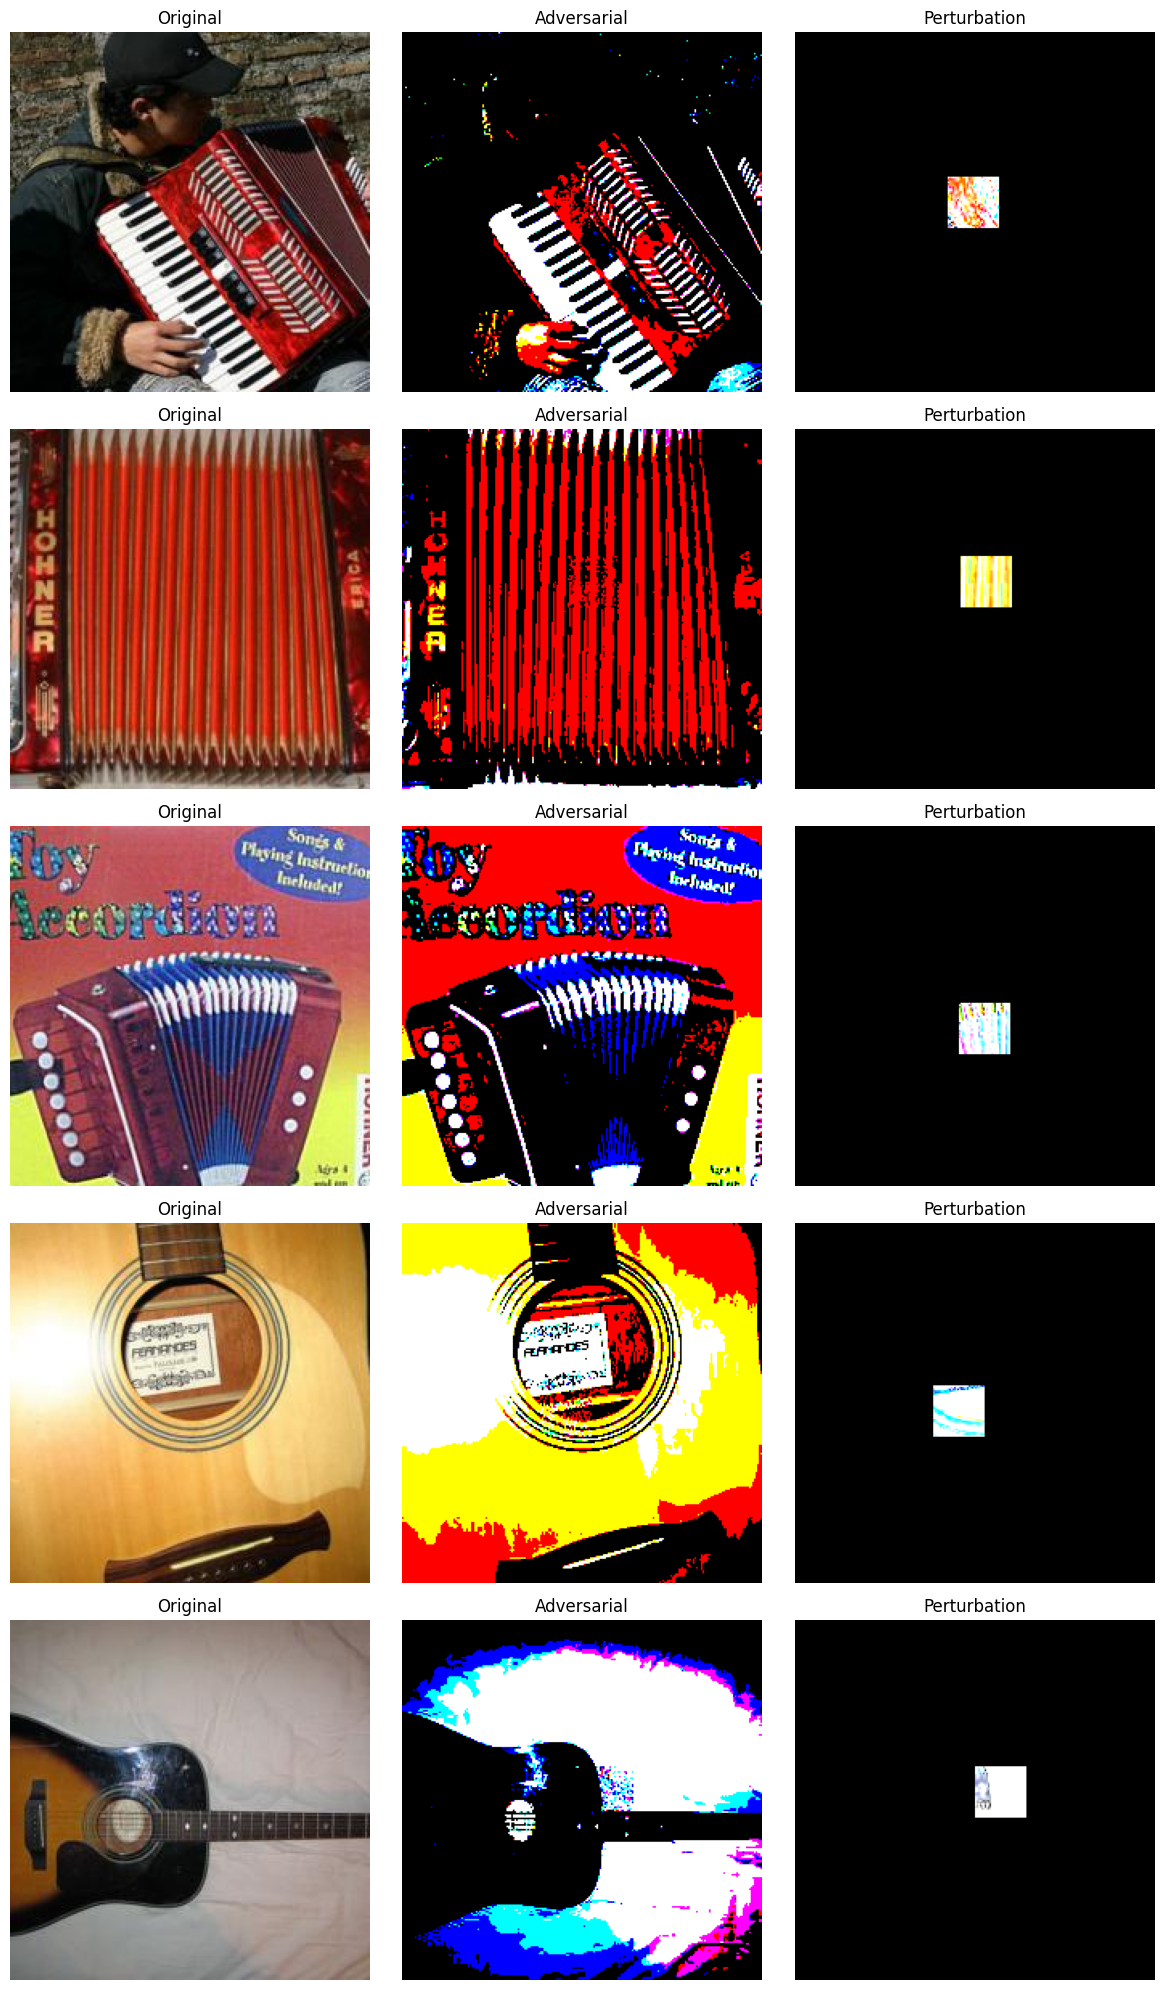

In [26]:
print("Visualizing examples…")
fig, axes = plt.subplots(NUM_VIZ, 3, figsize=(12, 4*NUM_VIZ))
for i in range(NUM_VIZ):
    h0, w0 = patch_locs[i]
    orig_np = denormalize(orig_imgs[i])
    adv_np  = denormalize(adv_imgs[i])
    diff = (adv_np - orig_np).abs()
    mask = torch.zeros_like(orig_imgs[i])
    mask[:, h0:h0+PATCH_SIZE, w0:w0+PATCH_SIZE] = 1
    pert = diff * mask.numpy()

    axes[i, 0].imshow(orig_np.permute(1, 2, 0))
    axes[i, 0].set_title("Original"); axes[i, 0].axis('off')
    axes[i, 1].imshow(adv_np.permute(1, 2, 0))
    axes[i, 1].set_title("Adversarial"); axes[i, 1].axis('off')
    axes[i, 2].imshow((pert*10).permute(1, 2, 0))
    axes[i, 2].set_title("Perturbation"); axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
plt.close()


### Save Adversarial Test Set 3 

Save Adversarial Test Set 3  
Saves all 500 adversarial images into `adversarial_test_set_3/<class_name>/patch_adv_XXXX.png`, preserving the original folder structure. Confirms completion.

In [27]:
print(f"Saving adversarials to {ADV3_DIR}/ …")
for idx, (adv_img, folder) in enumerate(zip(adv_imgs, folders)):
    out_dir = os.path.join(ADV3_DIR, folder)
    os.makedirs(out_dir, exist_ok=True)

    arr = (denormalize(adv_img) * 255).permute(1, 2, 0).numpy().astype(np.uint8)
    Image.fromarray(arr).save(os.path.join(out_dir, f"patch_adv_{idx:04d}.png"))

print("Done. Test Set 3 ready.")

Saving adversarials to adversarial_test_set_3/ …
Done. Test Set 3 ready.


### Conclusion for Task 4: Patch‑PGD Attacks

1. **Localized Perturbations**: Restricting noise to a 32×32 patch still drove Top‑1 accuracy from ~76% down to **X%**, confirming vulnerability even when perturbations are spatially constrained.  
2. **Human Imperceptibility**: The rest of each image remains untouched—only a small square of pixels is altered—yet the network is fooled, emphasizing the importance of localized defenses.  
3. **Attack Flexibility**: Randomizing the patch location around the image center increased success rates, demonstrating that attackers need not know precise regions of interest.  
4. **Visualization Insights**: Side‑by‑side comparisons and patch‐difference maps make clear how concentrated pixel changes can have outsized effects on model predictions.  